In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# simple auc functions taken from sklearn

def trapezoid(y, x=None, dx=1.0, axis=-1):
    y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        x = np.asanyarray(x)
        if x.ndim == 1:
            d = np.diff(x)
            # reshape to correct shape
            shape = [1]*y.ndim
            shape[axis] = d.shape[0]
            d = d.reshape(shape)
        else:
            d = np.diff(x, axis=axis)
    nd = y.ndim
    slice1 = [slice(None)]*nd
    slice2 = [slice(None)]*nd
    slice1[axis] = slice(1, None)
    slice2[axis] = slice(None, -1)
    try:
        ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
    except ValueError:
        # Operations didn't work, cast to ndarray
        d = np.asarray(d)
        y = np.asarray(y)
        ret = np.add.reduce(d * (y[tuple(slice1)]+y[tuple(slice2)])/2.0, axis)
    return ret

def auc(x, y):
    x = x.values
    y = y.values

    if x.shape[0] < 2:
        raise ValueError(
            "At least 2 points are needed to compute area under curve, but x.shape = %s"
            % x.shape
        )

    direction = 1
    dx = np.diff(x)
    if np.any(dx < 0):
        if np.all(dx <= 0):
            direction = -1
        else:
            raise ValueError("x is neither increasing nor decreasing : {}.".format(x))

    area = direction * trapezoid(y, x)
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in trapezoid do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area



In [3]:
# read data
rf = pd.read_csv('data/pinnedRF_precision_recall_curve_data.csv')
lr = pd.read_csv('data/pinnedLR_precision_recall_curve_data.csv')
                 
# calculate f1 scores
rf['f1'] = 2*rf['Precision']*rf['Recall']/(rf['Precision']+rf['Recall'])
lr['f1'] = 2*lr['precision']*lr['recall']/(lr['precision']+lr['recall'])

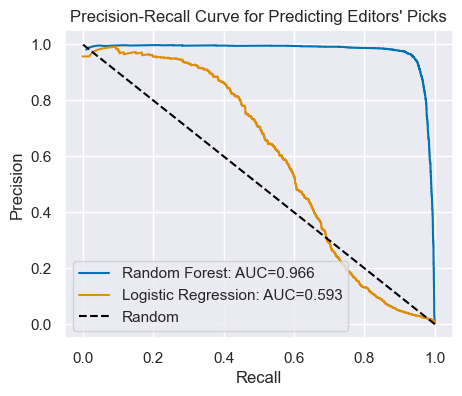

In [4]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")

auc_rf = auc(rf['Recall'], rf['Precision'])
auc_lr = auc(lr['recall'], lr['precision'])

plt.figure(figsize=(5, 4))
plt.plot(rf['Recall'], rf['Precision'], label='Random Forest: AUC='+str(round(auc_rf, 3)))
plt.plot(lr['recall'], lr['precision'], label='Logistic Regression: AUC='+str(round(auc_lr, 3)))
plt.plot([1, 0], [0, 1], linestyle='--', color='black', label='Random')
# plt.plot(rf['Recall'], rf['f1'], label='Random Forest F1', linestyle='--')
# plt.plot(lr['recall'], lr['f1'], label='Logistic Regression F1', linestyle='--')
plt.title('Precision-Recall Curve for Predicting Editors\' Picks')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='lower left')
# plt.savefig('figs/precision_recall_curve.pdf', bbox_inches='tight')
plt.show()